In [ ]:
!pip install deepface

     |████████████████████████████████| 61kB 5.1MB/s 
     |████████████████████████████████| 2.3MB 10.3MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-3.12.2-cp36-none-any.whl size=9693 sha256=2b5937d5c13faf07d7c338ee0d00e2b3f87965b7ffadccf5c75fc7c1679434e0
  Stored in directory: /root/.cache/pip/wheels/81/d0/d7/d9983facc6f2775411803e0e2d30ebf98efbf2fc6e57701e09
Successfully built gdown
  Found existing installation: gdown 3.6.4
    Uninstalling gdown-3.6.4:
      Successfully uninstalled gdown-3.6.4


In [ ]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
from deepface import DeepFace
from google.colab.patches import cv2_imshow
import sqlite3
from random import randint
import datetime
import os

Directory  /root /.deepface created
Directory  /root /.deepface/weights created


## Helper Functions
Below are a few helper function to make converting between different image data types and formats. 

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

**DRIVER CODE**


In [ ]:
#Creating database
db = sqlite3.connect("Customers.db")
db.execute("drop table if exists feedback")
try:
  db.execute("create table feedback(custmomer_id, feedback, filename, dateTime)")
except:
  print('Already table existed!')


<IPython.core.display.Javascript object>

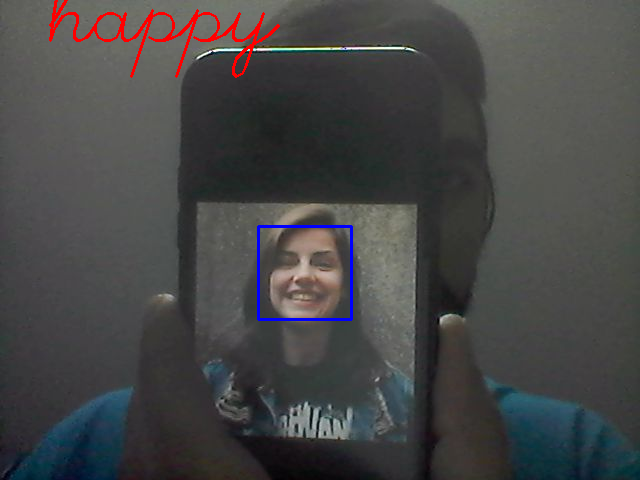

3.jpg


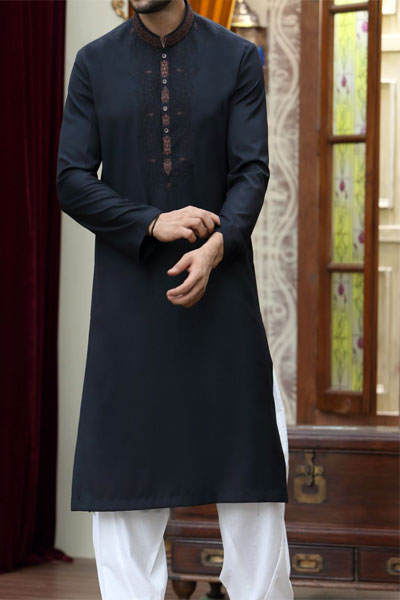

1.jpg


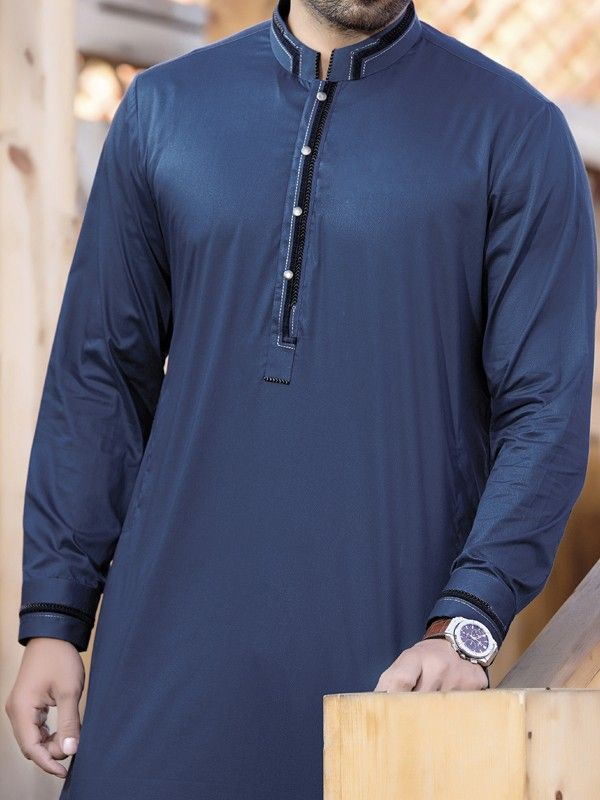

4.jpg


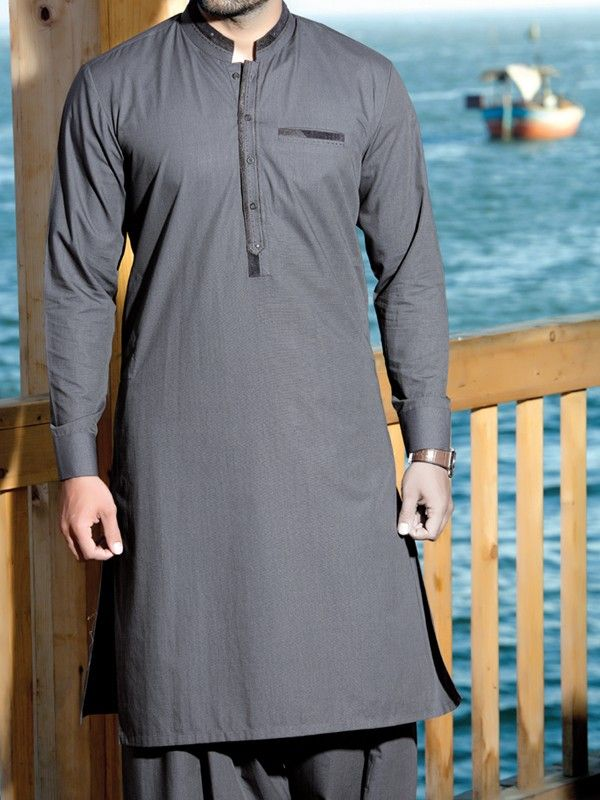

2.jpg


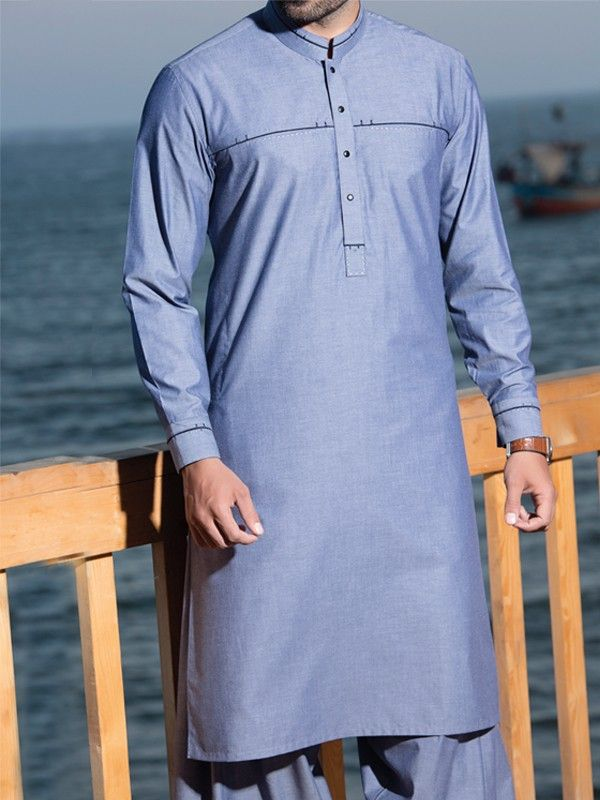

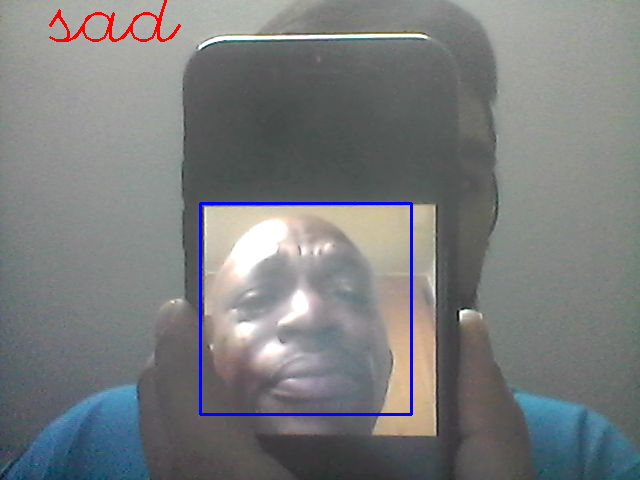

3.jpg


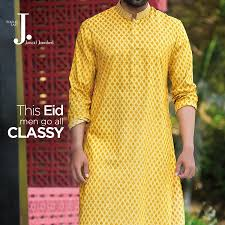

1.jpg


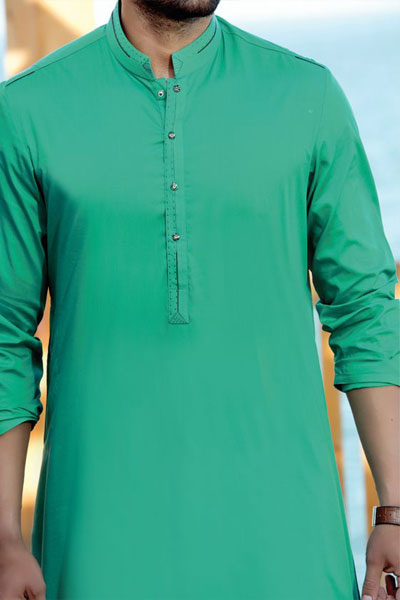

4.jpg


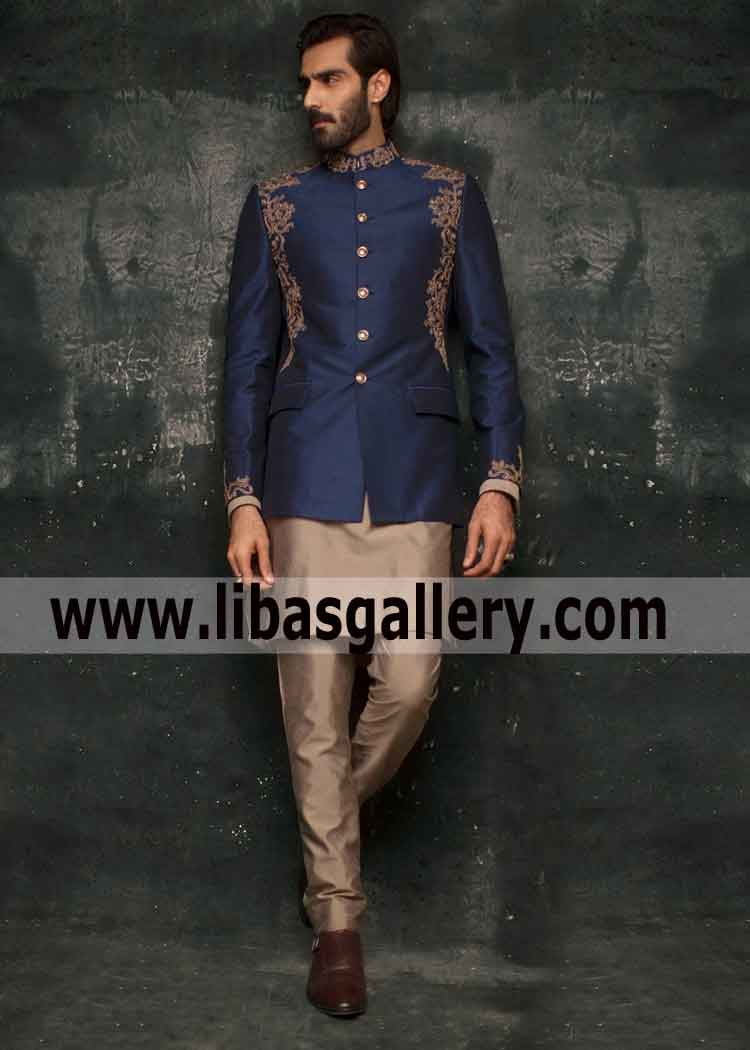

2.jpg


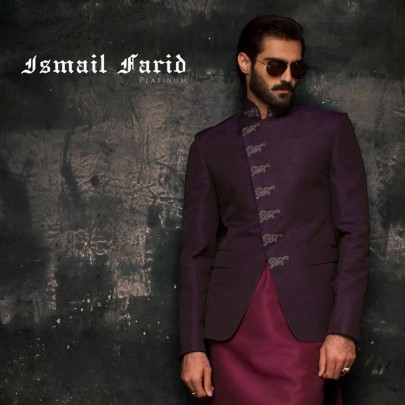

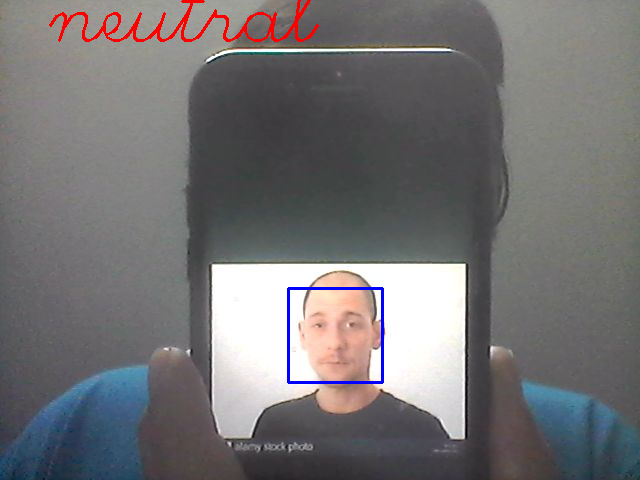

3.jpg


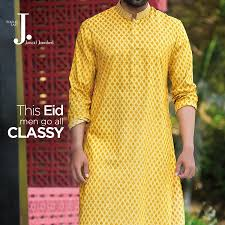

1.jpg


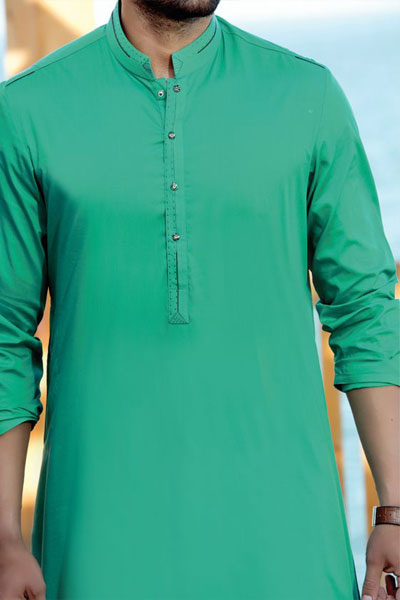

4.jpg


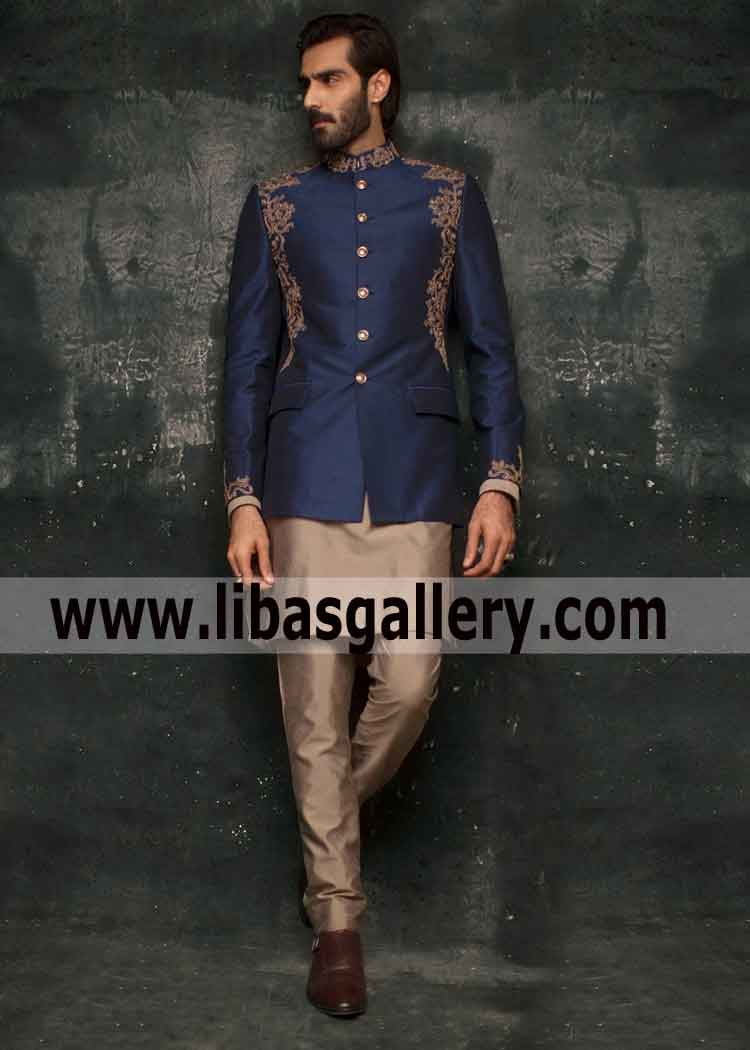

2.jpg


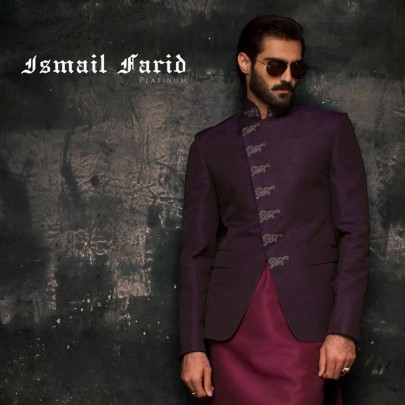

In [ ]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'

while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    result = DeepFace.analyze(img, actions = ['emotion'], enforce_detection=False)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    faces = faceCascade.detectMultiScale(gray)

    for (x,y,w,h) in faces:
       cv2.rectangle(img, (x,y), (x+w, y+h), (255,0,0), 2)

    font= cv2.FONT_HERSHEY_SCRIPT_SIMPLEX

    cv2.putText(img, result['dominant_emotion'],
    (50,40),
    font, 3,
    (0,0,255),
    2,
    cv2.LINE_4)

    cv2_imshow(img)

    if (result['dominant_emotion'] == 'happy'):

        #saving image on local machine
        customer_id = randint(1, 999999)
        filename = "Happy/"+str(customer_id) + '.jpg'
        dateTime = datetime.datetime.now()
        dateTime= dateTime.strftime("%c")
        
        
        cv2.imwrite(filename, img )

        #Saving feedback to database
        query = "insert into feedback(custmomer_id, feedback, filename, dateTime) values('{}', '{}', '{}', '{}')".format(customer_id, result['dominant_emotion'], filename, dateTime)
        db.execute(query)
        db.commit()

        #Suggestion code
        path = '/content/similar'
        for i in os.listdir(path):
          ext = i.split(".")[1]
          if (ext == 'jpg'):
            print(i)
            image = cv2.imread(os.path.join(path, i))
            cv2_imshow(image)
        time.sleep(10)

    elif (result['dominant_emotion'] == 'neutral' or result['dominant_emotion'] == 'sad'):
      #saving image on local machine
        customer_id = randint(1, 999999)
        filename = "NotHappy/"+str(customer_id) + '.jpg'
        dateTime = datetime.datetime.now()
        dateTime= dateTime.strftime("%c")
        
        
        cv2.imwrite(filename, img )

        #Saving feedback to database
        query = "insert into feedback(custmomer_id, feedback, filename, dateTime) values('{}', '{}', '{}', '{}')".format(customer_id, result['dominant_emotion'], filename, dateTime)
        db.execute(query)
        db.commit()

        #Suggestion code
        path = '/content/different/'
        for i in os.listdir(path):
          ext = i.split(".")[1]
          if (ext == 'jpg'):
            print(i)
            image = cv2.imread(os.path.join(path, i))
            cv2_imshow(image)
        time.sleep(10)




In [ ]:
db = sqlite3.connect("Customers.db")
rows = db.execute("select * from feedback")
for i in rows:
  print(i)

In [ ]:

from google.colab.patches import cv2_imshow
path = '/content/similar'
for i in os.listdir(path):
  ext = i.split(".")[1]
  if (ext == 'jpg'):
    print(i)
    image = cv2.imread(os.path.join(path, i))
    cv2_imshow(image)


In [ ]:
!mkdir NotHappy
!mkdir Happy
!mkdir similar
!mkdir different


mkdir: cannot create directory ‘NotHappy’: File exists


In [ ]:
cd similar/

/content


In [ ]:
from google.colab import files

uploaded = files.upload()